# Workflow Interface 104: Working with Keras
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intel/openfl/blob/develop/openfl-tutorials/experimental/Workflow_Interface_104_Keras_MNIST_with_GPU.ipynb)

In this tutorial, we will demonstrate how to use Keras with Workflow Interface. Even though this tutorial is meant to be ran with GPU, in case GPU is not available this can be ran on CPU as well by changing `num_gpus=0.3` to `num_gpus=0`.

# Getting Started

First we start by installing the necessary dependencies for the workflow interface. Please note if you intent to run this tutorial on GPU then install CUDA and cuDNN versions for TensorFlow 2.7 as mentioned [here](https://www.tensorflow.org/install/source#gpu).

In [ ]:
!pip install git+https://github.com/securefederatedai/openfl.git
!pip install -r workflow_interface_requirements.txt
!pip install tensorflow

# Uncomment this if running in Google Colab
# !pip install -r https://raw.githubusercontent.com/intel/openfl/develop/openfl-tutorials/experimental/workflow_interface_requirements.txt
# import os
# os.environ["USERNAME"] = "colab"

Configure Tensorflow to allocate GPU memory as it is needed by the processes (instead of TF default policy to allocate nearly all of the memory on GPUs). Refer [Limiting GPU memory growth](https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth)

IMPORTANT NOTE: This is needed to demonstrate fractional usage of GPUs by Ray backend and avoid conflict between Ray and Tensorflow while allocating GPU memory

In [ ]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

We begin with the quintessential example of a small keras CNN model trained on the MNIST dataset. Let's start define our dataloaders, model, optimizer, and some helper functions like we would for any other deep learning experiment

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

nb_classes = 10
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255.0
X_test /= 255.0
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)


model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)),
    MaxPool2D(),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.2),
    Dense(512, activation="relu"),
    Dropout(0.2),
    Dense(nb_classes, activation="softmax"),
])

model.compile(optimizer="SGD", loss="categorical_crossentropy", metrics=["accuracy"])
print(model.summary())


def inference(model, test_loader, batch_size):
    x_test, y_test = test_loader
    loss, accuracy = model.evaluate(
        x_test,
        y_test,
        batch_size=batch_size,
        verbose=0
    )
    accuracy_percentage = accuracy * 100
    print(f"Test set: Avg. loss: {loss}, Accuracy: {accuracy_percentage:.2f}%")
    return accuracy

Next we import the `FLSpec`, `LocalRuntime`, and placement decorators.

- `FLSpec` – Defines the flow specification. User defined flows are subclasses of this.
- `Runtime` – Defines where the flow runs, infrastructure for task transitions (how information gets sent). The `LocalRuntime` runs the flow on a single node.
- `aggregator/collaborator` - placement decorators that define where the task will be assigned

In [ ]:
from openfl.experimental.interface import FLSpec, Aggregator, Collaborator
from openfl.experimental.runtime import LocalRuntime
from openfl.experimental.placement import aggregator, collaborator
import numpy as np


def FedAvg(models):
    new_model = models[0]
    state_dicts = [model.weights for model in models]
    state_dict = new_model.weights
    for idx, _ in enumerate(models[1].weights):
        state_dict[idx] = np.sum(np.array([state[idx]
                                 for state in state_dicts], dtype=object), axis=0) / len(models)
    new_model.set_weights(state_dict)
    return new_model

Now we come to the flow definition. The OpenFL Workflow Interface adopts the conventions set by Metaflow, that every workflow begins with `start` and concludes with the `end` task. The aggregator begins with an optionally passed in model and optimizer. The aggregator begins the flow with the `start` task, where the list of collaborators is extracted from the runtime (`self.collaborators = self.runtime.collaborators`) and is then used as the list of participants to run the task listed in `self.next`, `aggregated_model_validation`. The model, optimizer, and anything that is not explicitly excluded from the next function will be passed from the `start` function on the aggregator to the `aggregated_model_validation` task on the collaborator. Where the tasks run is determined by the placement decorator that precedes each task definition (`@aggregator` or `@collaborator`). Once each of the collaborators (defined in the runtime) complete the `aggregated_model_validation` task, they pass their current state onto the `train` task, from `train` to `local_model_validation`, and then finally to `join` at the aggregator. It is in `join` that an average is taken of the model weights, and the next round can begin.

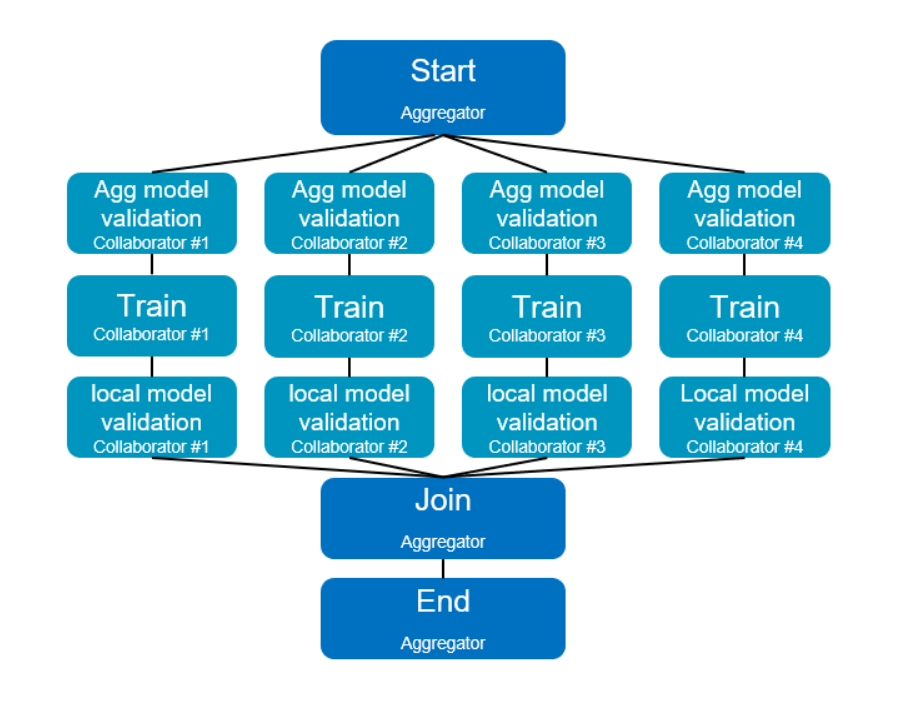

In [ ]:
class KerasMNISTFlow(FLSpec):
    def __init__(self, model, rounds=3, **kwargs):
        super().__init__(**kwargs)
        self.model = model
        self.n_rounds = rounds
        self.current_round = 1

    @aggregator
    def start(self):
        self.collaborators = self.runtime.collaborators
        self.next(self.aggregated_model_validation, foreach='collaborators')

    @collaborator
    def aggregated_model_validation(self):
        print(f'Performing aggregated model validation for collaborator {self.input}')
        self.agg_validation_score = inference(self.model, self.test_loader, self.batch_size)
        print(f'{self.input} value of {self.agg_validation_score}')
        self.next(self.train)

    @collaborator
    def train(self):
        x_train, y_train = self.train_loader
        history = self.model.fit(
            x_train, y_train,
            batch_size=self.batch_size,
            epochs=1,
            verbose=1,
        )
        self.loss = history.history["loss"][0]
        self.next(self.local_model_validation)

    @collaborator
    def local_model_validation(self):
        self.local_validation_score = inference(self.model, self.test_loader, self.batch_size)
        print(
            f'Doing local model validation for collaborator {self.input}: {self.local_validation_score}')
        self.next(self.join)

    @aggregator
    def join(self, inputs):
        self.average_loss = sum(input.loss for input in inputs) / len(inputs)
        self.aggregated_model_accuracy = sum(
            input.agg_validation_score for input in inputs) / len(inputs)
        self.local_model_accuracy = sum(
            input.local_validation_score for input in inputs) / len(inputs)
        print(f'Average aggregated model validation values = {self.aggregated_model_accuracy}')
        print(f'Average training loss = {self.average_loss}')
        print(f'Average local model validation values = {self.local_model_accuracy}')
        print("Taking FedAvg of models of all collaborators")
        self.model = FedAvg([input.model for input in inputs])

        self.next(self.internal_loop)

    @aggregator
    def internal_loop(self):
        if self.current_round == self.n_rounds:
            self.next(self.end)
        else:
            self.current_round += 1
            self.next(self.aggregated_model_validation, foreach='collaborators')

    @aggregator
    def end(self):
        print(f'This is the end of the flow')

Note that the private attributes are flexible, and you can choose to pass in a completely different type of object to any of the collaborators or aggregator (with an arbitrary name). These private attributes will always be filtered out of the current state when transferring from collaborator to aggregator, or vice versa.  

Private attributes can be set using callback function while instantiating the participant. Parameters required by the callback function are specified as arguments while instantiating the participant. In this example callback function, `callable_to_initialize_collaborator_private_attributes`, returns the private attributes `train_loader`, `test_loader` and `batch_size` of the collaborator. Parameters required by the callback function `index`, `n_collaborators`, `batch_size`, `train_dataset`, `test_dataset` are passed appropriate values with the same names in the Collaborator constructor.

In [ ]:
agg = Aggregator()

collaborator_names = ["Portland", "Seattle"]

def callable_to_initialize_collaborator_private_attributes(n_collaborators, index, train_dataset, test_dataset, batch_size):
    from openfl.utilities.data_splitters import EqualNumPyDataSplitter
    train_splitter = EqualNumPyDataSplitter()
    test_splitter = EqualNumPyDataSplitter()

    X_train, y_train = train_dataset
    X_test, y_test = test_dataset

    train_idx = train_splitter.split(y_train, n_collaborators)
    valid_idx = test_splitter.split(y_test, n_collaborators)

    train_dataset = X_train[train_idx[index]], y_train[train_idx[index]]
    test_dataset = X_test[valid_idx[index]], y_test[valid_idx[index]]

    return {
        "train_loader": train_dataset, "test_loader": test_dataset,
        "batch_size": batch_size
    }

# Setup collaborators private attributes via callable function
collaborators = []
for idx, collaborator_name in enumerate(collaborator_names):
    collaborators.append(
        Collaborator(
            name=collaborator_name, num_cpus=0, num_gpus=0.3,
            private_attributes_callable=callable_to_initialize_collaborator_private_attributes,
            n_collaborators=len(collaborator_names), index=idx, train_dataset=(X_train, Y_train),
            test_dataset=(X_test, Y_test), batch_size=32
        )
    )

local_runtime = LocalRuntime(aggregator=agg, collaborators=collaborators, backend="ray")
print(f'Local runtime collaborators = {local_runtime.collaborators}')

Now that we have our flow and runtime defined, let's run the experiment! 

In [ ]:
flflow = KerasMNISTFlow(model, rounds=3, checkpoint=True)
flflow.runtime = local_runtime
flflow.run()

# Congratulations!
Now that you've completed your this notebook, see some of the more advanced things you can do in our [other tutorials](broken_link), including:

- Using the LocalRuntime Ray Backend for dedicated GPU access
- Vertical Federated Learning
- Model Watermarking
- Differential Privacy
- And More!